In [1]:
%cd ..

import os
import torch
import torch.nn as nn
import torch.optim as optim
import copy

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

from alignment.alignment_utils import load_deep_jscc, get_batch_psnr
from alignment.alignment_model import _ConvolutionalAlignment, _LinearAlignment, AlignedDeepJSCC
from utils import image_normalization
import matplotlib.pyplot as plt

from dataset import Vanilla
from model import DeepJSCC
from tqdm import tqdm
import pickle
import random
import numpy as np

import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from torch.utils.data import DataLoader, Subset

/home/lorenzo/repos/Deep-JSCC-PyTorch


In [2]:
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'
saved = r'out/checkpoints/CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025/epoch_999.pkl'

snr = 7
times = 10

dataset = "cifar10"
resolution = 64

batch_size = 64
num_workers = 4
channel = 'AWGN'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Init

In [3]:
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    seed = seed
    return seed

seed = set_all_seeds(42)

In [4]:
############
# GET DATA #
############

if dataset == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.CIFAR10(root='../dataset/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.CIFAR10(root='../dataset/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenet':
    # the size of paper is 128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    print("loading data of imagenet")

    train_dataset = datasets.ImageFolder(root='./dataset/ImageNet/train', transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    test_dataset = Vanilla(root='./dataset/ImageNet/val', transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenette':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.Imagenette(root='../dataset/', split="train", download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.Imagenette(root='../dataset/', split="val", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

else:
    raise Exception('Unknown dataset')

In [5]:
class AlignmentDataset(Dataset):
    def __init__(self, dataloader, model1, model2, flat=False):
        self.outputs = []

        model1.eval()
        model1.to(device)

        model2.eval()
        model2.to(device)

        with torch.no_grad():
            for inputs, _ in tqdm(dataloader, desc="Computing model outputs"):
                inputs = inputs.to(device)

                out1 = model1(inputs)
                out2 = model2(inputs)

                for o1, o2 in zip(out1, out2):
                    if flat:
                        o1 = o1.flatten()
                        o2 = o2.flatten()

                    self.outputs.append((o1.cpu(), o2.cpu()))

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.outputs[idx]  

In [6]:
def validation(model, dataloader, times):

    model = model.to(device)
    batch_psnr_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:

            inputs = inputs.to(device)
            psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                gt = image_normalization('denormalization')(inputs)
                psnr += get_batch_psnr(demo_image, gt)

            psnr /= times
            batch_mean_psnr = psnr.mean().item()
            batch_psnr_list.append(batch_mean_psnr)

    overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

    return overall_mean_psnr

def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    file_name = os.path.basename(os.path.dirname(saved))
    c = file_name.split('_')[1]
    c = int(c)
    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

In [7]:
def validation_worker(model, inputs, gt, times, worker_id):
    """Worker function for parallel model inference"""
    model.eval()
    psnr_sum = torch.zeros(inputs.shape[0], device=inputs.device)
    
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(inputs)
            demo_image = image_normalization('denormalization')(demo_image)
            psnr_sum += get_batch_psnr(demo_image, gt)
    
    return psnr_sum / times

def validation_parallel_inference(model, dataloader, times, num_workers=None):
    """Version with parallel inference for multiple runs"""
    model = model.to(device)
    model.eval()
    
    # Auto-detect optimal number of workers
    if num_workers is None:
        num_workers = min(times, torch.cuda.device_count() if torch.cuda.is_available() else mp.cpu_count())
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                # No need for parallelization with single run
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Parallel inference for multiple runs
                runs_per_worker = times // num_workers
                remaining_runs = times % num_workers
                
                batch_psnr_sum = torch.zeros(batch_size, device=device)
                
                # Use thread pool for GPU parallelization (better for CUDA)
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = []
                    
                    # Submit jobs with different number of runs per worker
                    for i in range(num_workers):
                        worker_runs = runs_per_worker + (1 if i < remaining_runs else 0)
                        if worker_runs > 0:
                            future = executor.submit(
                                validation_worker, 
                                model, inputs, gt, worker_runs, i
                            )
                            futures.append(future)
                    
                    # Collect results
                    for future in futures:
                        batch_psnr_sum += future.result()
                
                batch_psnr = batch_psnr_sum.sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

def validation_parallel_batches(model, dataloader, times, num_workers=4):
    """Version with parallel batch processing"""
    model = model.to(device)
    model.eval()
    
    def process_batch(batch_data):
        inputs, *_ = batch_data
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]
        
        # Denormalize ground truth once
        gt = image_normalization('denormalization')(inputs)
        
        # Accumulate PSNR across multiple runs
        batch_psnr_sum = torch.zeros(batch_size, device=device)
        
        with torch.no_grad():
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
        
        batch_mean_psnr = (batch_psnr_sum / times).sum().item()
        return batch_mean_psnr, batch_size
    
    # Process batches in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_batch, dataloader))
    
    total_psnr = sum(psnr for psnr, _ in results)
    total_samples = sum(samples for _, samples in results)
    
    return total_psnr / total_samples

def validation_vectorized(model, dataloader, times):
    """Vectorized version for maximum efficiency when memory allows"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Vectorized computation - process all runs at once
                # Repeat inputs for all runs
                inputs_repeated = inputs.repeat(times, 1, 1, 1)
                
                # Single forward pass for all runs
                demo_images = model(inputs_repeated)
                demo_images = image_normalization('denormalization')(demo_images)
                
                # Reshape to separate runs and batch dimension
                demo_images = demo_images.view(times, batch_size, *demo_images.shape[1:])
                gt_repeated = gt.unsqueeze(0).repeat(times, 1, 1, 1, 1)
                
                # Compute PSNR for all runs at once
                psnr_all_runs = torch.stack([
                    get_batch_psnr(demo_images[i], gt_repeated[i]) 
                    for i in range(times)
                ])
                
                # Average across runs and sum across batch
                batch_psnr = psnr_all_runs.mean(dim=0).sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Main validation function with automatic method selection
def validation(model, dataloader, times, method='auto', num_workers=None):
    """
    Optimized validation with multiple parallelization strategies
    
    Args:
        model: The model to validate
        dataloader: Data loader for validation data
        times: Number of inference runs per sample
        method: 'auto', 'vectorized', 'parallel_inference', 'parallel_batches', or 'sequential'
        num_workers: Number of parallel workers (auto-detected if None)
    """
    
    if method == 'auto':
        # Auto-select best method based on conditions
        if times == 1:
            method = 'sequential'
        elif times <= 4 and torch.cuda.is_available():
            method = 'vectorized'  # Best for GPU with moderate times
        elif times > 4:
            method = 'parallel_inference'  # Best for many inference runs
        else:
            method = 'parallel_batches'  # Best for CPU or complex cases
    
    if method == 'vectorized':
        return validation_vectorized(model, dataloader, times)
    elif method == 'parallel_inference':
        return validation_parallel_inference(model, dataloader, times, num_workers)
    elif method == 'parallel_batches':
        return validation_parallel_batches(model, dataloader, times, num_workers)
    else:  # sequential
        return validation_sequential(model, dataloader, times)

def validation_sequential(model, dataloader, times):
    """Original optimized sequential version for comparison"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            gt = image_normalization('denormalization')(inputs)
            batch_psnr_sum = torch.zeros(batch_size, device=device)
            
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
            
            batch_mean_psnr = (batch_psnr_sum / times).sum().item()
            total_psnr += batch_mean_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Train

## Functions

In [ ]:
def increasing_dataset_size():
    batch_size = 1024
    n_batches = 50000
    c = 8
    granularity = 1
    model1 = load_from_checkpoint(model1_fp, snr).encoder
    model2 = load_from_checkpoint(model2_fp, snr).encoder

    subset_sizes = [i * granularity for i in range(1, n_batches + 1)]

    data = AlignmentDataset(train_loader, model1, model2, flat=False)
    order = torch.randperm(len(data))

    # save order
    with open('order.txt', 'w') as f:
        f.write(str(order))

    for n in subset_sizes:
        # initialize dataset
        indices = order[:n]
        subset = Subset(data, indices)
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

        # initialize aligner
        aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5)
        epochs = 100
        criterion = nn.MSELoss()
        optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

        # train aligner
        for _ in range(epochs):
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = aligner(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # save aligner
        with open(r'alignment/models/incremental/aligner_'+str(n)+'.pkl', 'wb') as f:
            pickle.dump(aligner, f)

        print(f"Done with {n}.")

In [19]:
def increasing_dataset_size():
    batch_size = 1024
    n_batches = 50000
    c = 8
    granularity = 128
    patience = 5  # Number of checks with no improvement to wait
    check_interval = 100  # How many epochs between validation checks
    min_delta = 1e-5  # Minimum change to count as improvement

    model1 = load_from_checkpoint(model1_fp, snr).encoder
    model2 = load_from_checkpoint(model2_fp, snr).encoder

    subset_sizes = [i * granularity for i in range(1, n_batches + 1)]

    data = AlignmentDataset(train_loader, model1, model2, flat=False)
    order = torch.randperm(len(data))

    # Save order
    with open('order.txt', 'w') as f:
        f.write(str(order.tolist()))

    for n in subset_sizes:
        indices = order[:n]
        subset = Subset(data, indices)
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

        aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

        best_loss = float('inf')
        checks_without_improvement = 0
        epoch = 0

        while True:
            epoch_loss = 0.0

            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = aligner(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            epoch += 1

            if epoch % check_interval == 0:
                avg_loss = epoch_loss / len(dataloader)
                if best_loss - avg_loss > min_delta:
                    best_loss = avg_loss
                    checks_without_improvement = 0
                else:
                    checks_without_improvement += 1

                if checks_without_improvement >= patience:
                    break

        # Save aligner
        with open(f'alignment/models/incremental/aligner_{n}.pkl', 'wb') as f:
            pickle.dump(aligner, f)

        print(f"Done with {n}. Trained for {epoch} epochs.")

## Exec

In [9]:
increasing_dataset_size()

Computing model outputs: 100%|██████████| 782/782 [00:12<00:00, 61.38it/s]


Done with 1. Trained for 2500 epochs.
Done with 2. Trained for 6400 epochs.
Done with 3. Trained for 5200 epochs.
Done with 4. Trained for 4100 epochs.
Done with 5. Trained for 4400 epochs.
Done with 6. Trained for 3800 epochs.
Done with 7. Trained for 3800 epochs.
Done with 8. Trained for 3700 epochs.
Done with 9. Trained for 3500 epochs.
Done with 10. Trained for 3500 epochs.
Done with 11. Trained for 3400 epochs.
Done with 12. Trained for 3800 epochs.
Done with 13. Trained for 3600 epochs.
Done with 14. Trained for 3300 epochs.
Done with 15. Trained for 3600 epochs.
Done with 16. Trained for 3500 epochs.
Done with 17. Trained for 3600 epochs.
Done with 18. Trained for 3400 epochs.
Done with 19. Trained for 3300 epochs.
Done with 20. Trained for 3600 epochs.
Done with 21. Trained for 3600 epochs.
Done with 22. Trained for 3500 epochs.
Done with 23. Trained for 3600 epochs.
Done with 24. Trained for 3500 epochs.
Done with 25. Trained for 3500 epochs.
Done with 26. Trained for 4100 epo

KeyboardInterrupt: 

In [20]:
increasing_dataset_size()

Computing model outputs: 100%|██████████| 782/782 [00:10<00:00, 73.56it/s] 


Done with 128. Trained for 3600 epochs.
Done with 256. Trained for 3800 epochs.
Done with 384. Trained for 3200 epochs.
Done with 512. Trained for 3500 epochs.
Done with 640. Trained for 3500 epochs.
Done with 768. Trained for 3300 epochs.
Done with 896. Trained for 3400 epochs.
Done with 1024. Trained for 3400 epochs.
Done with 1152. Trained for 1100 epochs.
Done with 1280. Trained for 1300 epochs.
Done with 1408. Trained for 2400 epochs.
Done with 1536. Trained for 1500 epochs.
Done with 1664. Trained for 1600 epochs.
Done with 1792. Trained for 1700 epochs.
Done with 1920. Trained for 1500 epochs.
Done with 2048. Trained for 2100 epochs.
Done with 2176. Trained for 900 epochs.
Done with 2304. Trained for 1800 epochs.
Done with 2432. Trained for 1000 epochs.
Done with 2560. Trained for 1200 epochs.
Done with 2688. Trained for 1600 epochs.
Done with 2816. Trained for 2400 epochs.
Done with 2944. Trained for 1600 epochs.
Done with 3072. Trained for 1600 epochs.
Done with 3200. Trained 

KeyboardInterrupt: 

# Validate

## Functions

In [10]:
def validation_worker(model, inputs, gt, times, worker_id):
    """Worker function for parallel model inference"""
    model.eval()
    psnr_sum = torch.zeros(inputs.shape[0], device=inputs.device)
    
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(inputs)
            demo_image = image_normalization('denormalization')(demo_image)
            psnr_sum += get_batch_psnr(demo_image, gt)
    
    return psnr_sum / times

def validation_parallel_inference(model, dataloader, times, num_workers=None):
    """Version with parallel inference for multiple runs"""
    model = model.to(device)
    model.eval()
    
    # Auto-detect optimal number of workers
    if num_workers is None:
        num_workers = min(times, torch.cuda.device_count() if torch.cuda.is_available() else mp.cpu_count())
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                # No need for parallelization with single run
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Parallel inference for multiple runs
                runs_per_worker = times // num_workers
                remaining_runs = times % num_workers
                
                batch_psnr_sum = torch.zeros(batch_size, device=device)
                
                # Use thread pool for GPU parallelization (better for CUDA)
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = []
                    
                    # Submit jobs with different number of runs per worker
                    for i in range(num_workers):
                        worker_runs = runs_per_worker + (1 if i < remaining_runs else 0)
                        if worker_runs > 0:
                            future = executor.submit(
                                validation_worker, 
                                model, inputs, gt, worker_runs, i
                            )
                            futures.append(future)
                    
                    # Collect results
                    for future in futures:
                        batch_psnr_sum += future.result()
                
                batch_psnr = batch_psnr_sum.sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

def validation_parallel_batches(model, dataloader, times, num_workers=4):
    """Version with parallel batch processing"""
    model = model.to(device)
    model.eval()
    
    def process_batch(batch_data):
        inputs, *_ = batch_data
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]
        
        # Denormalize ground truth once
        gt = image_normalization('denormalization')(inputs)
        
        # Accumulate PSNR across multiple runs
        batch_psnr_sum = torch.zeros(batch_size, device=device)
        
        with torch.no_grad():
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
        
        batch_mean_psnr = (batch_psnr_sum / times).sum().item()
        return batch_mean_psnr, batch_size
    
    # Process batches in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_batch, dataloader))
    
    total_psnr = sum(psnr for psnr, _ in results)
    total_samples = sum(samples for _, samples in results)
    
    return total_psnr / total_samples

def validation_vectorized(model, dataloader, times):
    """Vectorized version for maximum efficiency when memory allows"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Vectorized computation - process all runs at once
                # Repeat inputs for all runs
                inputs_repeated = inputs.repeat(times, 1, 1, 1)
                
                # Single forward pass for all runs
                demo_images = model(inputs_repeated)
                demo_images = image_normalization('denormalization')(demo_images)
                
                # Reshape to separate runs and batch dimension
                demo_images = demo_images.view(times, batch_size, *demo_images.shape[1:])
                gt_repeated = gt.unsqueeze(0).repeat(times, 1, 1, 1, 1)
                
                # Compute PSNR for all runs at once
                psnr_all_runs = torch.stack([
                    get_batch_psnr(demo_images[i], gt_repeated[i]) 
                    for i in range(times)
                ])
                
                # Average across runs and sum across batch
                batch_psnr = psnr_all_runs.mean(dim=0).sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Main validation function with automatic method selection
def validation(model, dataloader, times, method='auto', num_workers=None):
    """
    Optimized validation with multiple parallelization strategies
    
    Args:
        model: The model to validate
        dataloader: Data loader for validation data
        times: Number of inference runs per sample
        method: 'auto', 'vectorized', 'parallel_inference', 'parallel_batches', or 'sequential'
        num_workers: Number of parallel workers (auto-detected if None)
    """
    
    if method == 'auto':
        # Auto-select best method based on conditions
        if times == 1:
            method = 'sequential'
        elif times <= 4 and torch.cuda.is_available():
            method = 'vectorized'  # Best for GPU with moderate times
        elif times > 4:
            method = 'parallel_inference'  # Best for many inference runs
        else:
            method = 'parallel_batches'  # Best for CPU or complex cases
    
    if method == 'vectorized':
        return validation_vectorized(model, dataloader, times)
    elif method == 'parallel_inference':
        return validation_parallel_inference(model, dataloader, times, num_workers)
    elif method == 'parallel_batches':
        return validation_parallel_batches(model, dataloader, times, num_workers)
    else:  # sequential
        return validation_sequential(model, dataloader, times)

def validation_sequential(model, dataloader, times):
    """Original optimized sequential version for comparison"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            gt = image_normalization('denormalization')(inputs)
            batch_psnr_sum = torch.zeros(batch_size, device=device)
            
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
            
            batch_mean_psnr = (batch_psnr_sum / times).sum().item()
            total_psnr += batch_mean_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

## Exec

In [11]:
folder = r"alignment/models/incremental"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(1, 101+1):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 1 elements we get a PSNR of 16.89
For 2 elements we get a PSNR of 17.54
For 3 elements we get a PSNR of 21.97
For 4 elements we get a PSNR of 23.71
For 5 elements we get a PSNR of 24.96
For 6 elements we get a PSNR of 25.84
For 7 elements we get a PSNR of 25.52
For 8 elements we get a PSNR of 25.78
For 9 elements we get a PSNR of 25.93
For 10 elements we get a PSNR of 25.79
For 11 elements we get a PSNR of 26.39
For 12 elements we get a PSNR of 26.39
For 13 elements we get a PSNR of 26.46
For 14 elements we get a PSNR of 26.55
For 15 elements we get a PSNR of 26.35
For 16 elements we get a PSNR of 26.35
For 17 elements we get a PSNR of 26.28
For 18 elements we get a PSNR of 27.07
For 19 elements we get a PSNR of 27.13
For 20 elements we get a PSNR of 27.06
For 21 elements we get a PSNR of 26.98
For 22 elements we get a PSNR of 26.98
For 23 elements we get a PSNR of 27.00
For 24 elements we get a PSNR of 27.13
For 25 elements we get a PSNR of 27.14
For 26 elements we get a PSNR of 2

In [ ]:
"""
For 1 elements we get a PSNR of 15.38
For 2 elements we get a PSNR of 17.51
For 3 elements we get a PSNR of 19.41
For 4 elements we get a PSNR of 18.92
For 5 elements we get a PSNR of 20.42
For 6 elements we get a PSNR of 20.53
For 7 elements we get a PSNR of 20.76
For 8 elements we get a PSNR of 21.70
For 9 elements we get a PSNR of 21.85
For 10 elements we get a PSNR of 21.72
For 11 elements we get a PSNR of 21.51
For 12 elements we get a PSNR of 22.18
For 13 elements we get a PSNR of 22.21
For 14 elements we get a PSNR of 22.05
For 15 elements we get a PSNR of 22.22
For 16 elements we get a PSNR of 22.17
For 17 elements we get a PSNR of 22.44
For 18 elements we get a PSNR of 22.53
For 19 elements we get a PSNR of 22.52
For 20 elements we get a PSNR of 22.89
For 21 elements we get a PSNR of 23.10
For 22 elements we get a PSNR of 23.08
For 23 elements we get a PSNR of 23.09
For 24 elements we get a PSNR of 23.60
For 25 elements we get a PSNR of 23.29
For 26 elements we get a PSNR of 23.49
For 27 elements we get a PSNR of 23.86
For 28 elements we get a PSNR of 23.96
For 29 elements we get a PSNR of 24.03
For 30 elements we get a PSNR of 24.34
For 31 elements we get a PSNR of 24.56
For 32 elements we get a PSNR of 24.13
For 33 elements we get a PSNR of 24.27
For 34 elements we get a PSNR of 24.06
For 35 elements we get a PSNR of 24.42
For 36 elements we get a PSNR of 24.80
For 37 elements we get a PSNR of 24.35
For 38 elements we get a PSNR of 24.40
For 39 elements we get a PSNR of 24.37
For 40 elements we get a PSNR of 24.37
For 41 elements we get a PSNR of 24.61
For 42 elements we get a PSNR of 24.28
For 43 elements we get a PSNR of 24.07
For 44 elements we get a PSNR of 24.49
For 45 elements we get a PSNR of 24.57
For 46 elements we get a PSNR of 24.30
For 47 elements we get a PSNR of 24.27
For 48 elements we get a PSNR of 24.67
For 49 elements we get a PSNR of 24.73
For 50 elements we get a PSNR of 24.76
For 51 elements we get a PSNR of 24.99
For 52 elements we get a PSNR of 25.02
For 53 elements we get a PSNR of 24.96
For 54 elements we get a PSNR of 25.18
For 55 elements we get a PSNR of 25.02
For 56 elements we get a PSNR of 25.14
For 57 elements we get a PSNR of 25.44
For 58 elements we get a PSNR of 24.73
For 59 elements we get a PSNR of 25.13
For 60 elements we get a PSNR of 25.13
For 61 elements we get a PSNR of 25.19
For 62 elements we get a PSNR of 25.19
For 63 elements we get a PSNR of 25.31
For 64 elements we get a PSNR of 25.37
For 65 elements we get a PSNR of 25.26
For 66 elements we get a PSNR of 25.32
For 67 elements we get a PSNR of 25.45
For 68 elements we get a PSNR of 25.56
For 69 elements we get a PSNR of 25.37
For 70 elements we get a PSNR of 25.71
For 71 elements we get a PSNR of 25.37
For 72 elements we get a PSNR of 25.53
For 73 elements we get a PSNR of 25.31
For 74 elements we get a PSNR of 25.34
For 75 elements we get a PSNR of 25.58
For 76 elements we get a PSNR of 25.56
For 77 elements we get a PSNR of 25.36
For 78 elements we get a PSNR of 25.34
For 79 elements we get a PSNR of 25.56
For 80 elements we get a PSNR of 26.01
For 81 elements we get a PSNR of 25.61
For 82 elements we get a PSNR of 25.56
For 83 elements we get a PSNR of 25.67
For 84 elements we get a PSNR of 25.46
For 85 elements we get a PSNR of 25.41
For 86 elements we get a PSNR of 25.62
For 87 elements we get a PSNR of 25.78
For 88 elements we get a PSNR of 25.67
For 89 elements we get a PSNR of 25.68
For 90 elements we get a PSNR of 25.67
For 91 elements we get a PSNR of 25.76
For 92 elements we get a PSNR of 25.59
For 93 elements we get a PSNR of 25.34
For 94 elements we get a PSNR of 25.61
For 95 elements we get a PSNR of 25.83
For 96 elements we get a PSNR of 25.82
For 97 elements we get a PSNR of 25.88
For 98 elements we get a PSNR of 25.65
For 99 elements we get a PSNR of 25.72
For 100 elements we get a PSNR of 25.66
For 101 elements we get a PSNR of 25.65
For 102 elements we get a PSNR of 25.60
For 103 elements we get a PSNR of 25.69
For 104 elements we get a PSNR of 25.49
For 105 elements we get a PSNR of 25.63
For 106 elements we get a PSNR of 25.93
For 107 elements we get a PSNR of 25.74
For 108 elements we get a PSNR of 25.82
For 109 elements we get a PSNR of 25.94
For 110 elements we get a PSNR of 25.50
For 111 elements we get a PSNR of 25.70
For 112 elements we get a PSNR of 25.87
For 113 elements we get a PSNR of 25.69
For 114 elements we get a PSNR of 25.85
For 115 elements we get a PSNR of 25.77
For 116 elements we get a PSNR of 25.57
For 117 elements we get a PSNR of 25.60
For 118 elements we get a PSNR of 25.72
For 119 elements we get a PSNR of 25.68
For 120 elements we get a PSNR of 25.86
For 121 elements we get a PSNR of 25.66
For 122 elements we get a PSNR of 25.86
For 123 elements we get a PSNR of 25.98
For 124 elements we get a PSNR of 25.72
For 125 elements we get a PSNR of 25.85
For 126 elements we get a PSNR of 25.90
For 127 elements we get a PSNR of 26.05
For 128 elements we get a PSNR of 25.92
For 129 elements we get a PSNR of 25.82
For 130 elements we get a PSNR of 25.75
For 131 elements we get a PSNR of 26.15
For 132 elements we get a PSNR of 25.99
For 133 elements we get a PSNR of 26.11
For 134 elements we get a PSNR of 25.60
For 135 elements we get a PSNR of 25.96
For 136 elements we get a PSNR of 25.89
For 137 elements we get a PSNR of 26.19
For 138 elements we get a PSNR of 26.13
For 139 elements we get a PSNR of 25.92
For 140 elements we get a PSNR of 25.86
For 141 elements we get a PSNR of 25.83
For 142 elements we get a PSNR of 25.89
For 143 elements we get a PSNR of 26.03
For 144 elements we get a PSNR of 25.76
For 145 elements we get a PSNR of 25.97
For 146 elements we get a PSNR of 25.68
For 147 elements we get a PSNR of 26.16
For 148 elements we get a PSNR of 25.97
For 149 elements we get a PSNR of 25.74
For 150 elements we get a PSNR of 26.06
For 151 elements we get a PSNR of 26.05
For 152 elements we get a PSNR of 25.56
For 153 elements we get a PSNR of 26.14
For 154 elements we get a PSNR of 25.92
For 155 elements we get a PSNR of 26.16
For 156 elements we get a PSNR of 25.84
For 157 elements we get a PSNR of 25.79
For 158 elements we get a PSNR of 25.73
For 159 elements we get a PSNR of 25.97
For 160 elements we get a PSNR of 25.80
For 161 elements we get a PSNR of 25.81
For 162 elements we get a PSNR of 26.27
For 163 elements we get a PSNR of 26.01
For 164 elements we get a PSNR of 25.62
For 165 elements we get a PSNR of 25.84
For 166 elements we get a PSNR of 25.96
For 167 elements we get a PSNR of 25.97
For 168 elements we get a PSNR of 25.80
For 169 elements we get a PSNR of 25.88
For 170 elements we get a PSNR of 25.93
For 171 elements we get a PSNR of 25.98
For 172 elements we get a PSNR of 26.02
For 173 elements we get a PSNR of 26.15
For 174 elements we get a PSNR of 26.02
For 175 elements we get a PSNR of 25.76
For 176 elements we get a PSNR of 26.06
For 177 elements we get a PSNR of 25.95
For 178 elements we get a PSNR of 25.90
For 179 elements we get a PSNR of 25.96
For 180 elements we get a PSNR of 26.00
For 181 elements we get a PSNR of 26.05
For 182 elements we get a PSNR of 26.10
For 183 elements we get a PSNR of 25.78
For 184 elements we get a PSNR of 26.15
For 185 elements we get a PSNR of 26.08
For 186 elements we get a PSNR of 26.26
For 187 elements we get a PSNR of 26.22
For 188 elements we get a PSNR of 26.12
For 189 elements we get a PSNR of 26.18
For 190 elements we get a PSNR of 26.15
For 191 elements we get a PSNR of 26.20
For 192 elements we get a PSNR of 25.95
For 193 elements we get a PSNR of 26.26
For 194 elements we get a PSNR of 26.17
For 195 elements we get a PSNR of 26.16
For 196 elements we get a PSNR of 25.92
For 197 elements we get a PSNR of 25.82
For 198 elements we get a PSNR of 26.18
For 199 elements we get a PSNR of 26.13
For 200 elements we get a PSNR of 26.09
For 201 elements we get a PSNR of 26.02
For 202 elements we get a PSNR of 25.93
For 203 elements we get a PSNR of 25.93
For 204 elements we get a PSNR of 26.10
For 205 elements we get a PSNR of 26.07
For 206 elements we get a PSNR of 25.90
For 207 elements we get a PSNR of 26.11
For 208 elements we get a PSNR of 26.17
For 209 elements we get a PSNR of 26.16
For 210 elements we get a PSNR of 26.02
For 211 elements we get a PSNR of 26.14
For 212 elements we get a PSNR of 26.13
For 213 elements we get a PSNR of 26.11
For 214 elements we get a PSNR of 26.08
For 215 elements we get a PSNR of 26.29
For 216 elements we get a PSNR of 26.16
For 217 elements we get a PSNR of 26.26
For 218 elements we get a PSNR of 26.35
For 219 elements we get a PSNR of 26.14
For 220 elements we get a PSNR of 26.45
For 221 elements we get a PSNR of 26.03
For 222 elements we get a PSNR of 26.14

"""

## All

In [15]:
folder = r"alignment/models/incremental_42"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(900, 1100+1):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 900 elements we get a PSNR of 26.25
For 901 elements we get a PSNR of 26.15
For 902 elements we get a PSNR of 26.32
For 903 elements we get a PSNR of 26.15
For 904 elements we get a PSNR of 26.26
For 905 elements we get a PSNR of 26.46
For 906 elements we get a PSNR of 26.39
For 907 elements we get a PSNR of 26.63
For 908 elements we get a PSNR of 26.40
For 909 elements we get a PSNR of 26.53
For 910 elements we get a PSNR of 26.60
For 911 elements we get a PSNR of 26.28
For 912 elements we get a PSNR of 26.41
For 913 elements we get a PSNR of 26.48
For 914 elements we get a PSNR of 26.61
For 915 elements we get a PSNR of 26.14
For 916 elements we get a PSNR of 26.39
For 917 elements we get a PSNR of 26.40
For 918 elements we get a PSNR of 26.10
For 919 elements we get a PSNR of 26.45
For 920 elements we get a PSNR of 26.68
For 921 elements we get a PSNR of 26.17
For 922 elements we get a PSNR of 26.15
For 923 elements we get a PSNR of 26.24
For 924 elements we get a PSNR of 26.45


In [16]:
folder = r"alignment/models/incremental_43"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(900, 1100+1):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 900 elements we get a PSNR of 26.28
For 901 elements we get a PSNR of 26.00
For 902 elements we get a PSNR of 26.40
For 903 elements we get a PSNR of 26.44
For 904 elements we get a PSNR of 25.97
For 905 elements we get a PSNR of 26.11
For 906 elements we get a PSNR of 26.00
For 907 elements we get a PSNR of 26.43
For 908 elements we get a PSNR of 26.23
For 909 elements we get a PSNR of 26.35
For 910 elements we get a PSNR of 26.14
For 911 elements we get a PSNR of 26.41
For 912 elements we get a PSNR of 26.28
For 913 elements we get a PSNR of 26.29
For 914 elements we get a PSNR of 26.11
For 915 elements we get a PSNR of 26.21
For 916 elements we get a PSNR of 26.29
For 917 elements we get a PSNR of 26.05
For 918 elements we get a PSNR of 26.16
For 919 elements we get a PSNR of 26.22
For 920 elements we get a PSNR of 26.21
For 921 elements we get a PSNR of 25.98
For 922 elements we get a PSNR of 26.19
For 923 elements we get a PSNR of 26.14
For 924 elements we get a PSNR of 26.00


In [17]:
folder = r"alignment/models/incremental_44"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(900, 1100+1):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 900 elements we get a PSNR of 26.31
For 901 elements we get a PSNR of 26.37
For 902 elements we get a PSNR of 26.40
For 903 elements we get a PSNR of 26.20
For 904 elements we get a PSNR of 26.43
For 905 elements we get a PSNR of 26.53
For 906 elements we get a PSNR of 26.19
For 907 elements we get a PSNR of 26.56
For 908 elements we get a PSNR of 26.38
For 909 elements we get a PSNR of 26.15
For 910 elements we get a PSNR of 26.50
For 911 elements we get a PSNR of 26.40
For 912 elements we get a PSNR of 26.30
For 913 elements we get a PSNR of 26.30
For 914 elements we get a PSNR of 25.85
For 915 elements we get a PSNR of 26.58
For 916 elements we get a PSNR of 26.42
For 917 elements we get a PSNR of 26.30
For 918 elements we get a PSNR of 26.34
For 919 elements we get a PSNR of 26.10
For 920 elements we get a PSNR of 26.08
For 921 elements we get a PSNR of 26.40
For 922 elements we get a PSNR of 26.38
For 923 elements we get a PSNR of 26.43
For 924 elements we get a PSNR of 26.43


In [21]:
folder = r"alignment/models/incremental"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(128, 5000+1, 128):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 128 elements we get a PSNR of 27.95
For 256 elements we get a PSNR of 27.22
For 384 elements we get a PSNR of 27.52
For 512 elements we get a PSNR of 27.84
For 640 elements we get a PSNR of 27.97
For 768 elements we get a PSNR of 28.07
For 896 elements we get a PSNR of 28.11
For 1024 elements we get a PSNR of 28.11
For 1152 elements we get a PSNR of 28.12
For 1280 elements we get a PSNR of 28.25
For 1408 elements we get a PSNR of 28.19
For 1536 elements we get a PSNR of 28.20
For 1664 elements we get a PSNR of 28.32
For 1792 elements we get a PSNR of 28.31
For 1920 elements we get a PSNR of 28.32
For 2048 elements we get a PSNR of 28.36
For 2176 elements we get a PSNR of 28.32
For 2304 elements we get a PSNR of 28.23
For 2432 elements we get a PSNR of 28.32
For 2560 elements we get a PSNR of 28.34
For 2688 elements we get a PSNR of 28.37
For 2816 elements we get a PSNR of 28.36
For 2944 elements we get a PSNR of 28.42
For 3072 elements we get a PSNR of 28.43
For 3200 elements we ge

In [1]:
%cd ..

/home/lorenzo/repos/Deep-JSCC-PyTorch


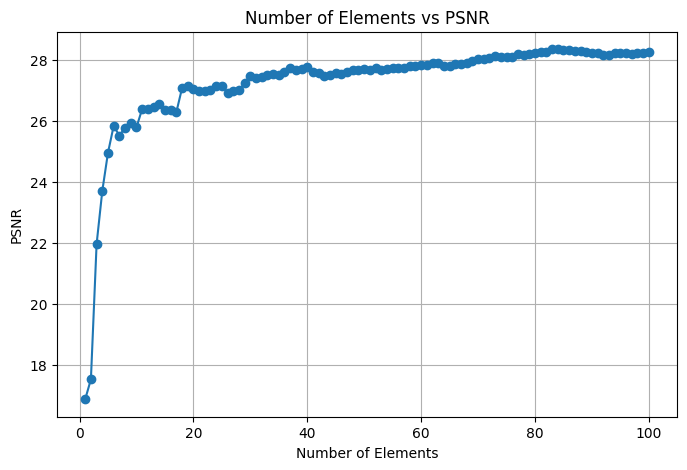

In [12]:
import re
import matplotlib.pyplot as plt

# Read the text from the file
with open(r'alignment/models/log_many.txt', 'r') as file:
    text = file.read()

# Extract numbers using regex
elements = []
psnr = []

# Find all matches like "For X elements we get a PSNR of Y"
matches = re.findall(r'For (\d+) elements.*?PSNR of ([\d\.]+)', text)

for match in matches:
    elements.append(int(match[0]))
    psnr.append(float(match[1]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(elements, psnr, marker='o')
plt.title('Number of Elements vs PSNR')
plt.xlabel('Number of Elements')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

In [16]:
text = """
Done with 1. Trained for 2500 epochs.
Done with 2. Trained for 6400 epochs.
Done with 3. Trained for 5200 epochs.
Done with 4. Trained for 4100 epochs.
Done with 5. Trained for 4400 epochs.
Done with 6. Trained for 3800 epochs.
Done with 7. Trained for 3800 epochs.
Done with 8. Trained for 3700 epochs.
Done with 9. Trained for 3500 epochs.
Done with 10. Trained for 3500 epochs.
Done with 11. Trained for 3400 epochs.
Done with 12. Trained for 3800 epochs.
Done with 13. Trained for 3600 epochs.
Done with 14. Trained for 3300 epochs.
Done with 15. Trained for 3600 epochs.
Done with 16. Trained for 3500 epochs.
Done with 17. Trained for 3600 epochs.
Done with 18. Trained for 3400 epochs.
Done with 19. Trained for 3300 epochs.
Done with 20. Trained for 3600 epochs.
Done with 21. Trained for 3600 epochs.
Done with 22. Trained for 3500 epochs.
Done with 23. Trained for 3600 epochs.
Done with 24. Trained for 3500 epochs.
Done with 25. Trained for 3500 epochs.
Done with 26. Trained for 4100 epochs.
Done with 27. Trained for 3800 epochs.
Done with 28. Trained for 3500 epochs.
Done with 29. Trained for 3600 epochs.
Done with 30. Trained for 3500 epochs.
Done with 31. Trained for 3700 epochs.
Done with 32. Trained for 3700 epochs.
Done with 33. Trained for 3500 epochs.
Done with 34. Trained for 3200 epochs.
Done with 35. Trained for 3700 epochs.
Done with 36. Trained for 3500 epochs.
Done with 37. Trained for 3500 epochs.
Done with 38. Trained for 3600 epochs.
Done with 39. Trained for 3500 epochs.
Done with 40. Trained for 3500 epochs.
Done with 41. Trained for 3500 epochs.
Done with 42. Trained for 3300 epochs.
Done with 43. Trained for 3900 epochs.
Done with 44. Trained for 3600 epochs.
Done with 45. Trained for 3200 epochs.
Done with 46. Trained for 3200 epochs.
Done with 47. Trained for 3600 epochs.
Done with 48. Trained for 3300 epochs.
Done with 49. Trained for 3500 epochs.
Done with 50. Trained for 3600 epochs.
Done with 51. Trained for 3500 epochs.
Done with 52. Trained for 3300 epochs.
Done with 53. Trained for 3400 epochs.
Done with 54. Trained for 3500 epochs.
Done with 55. Trained for 3300 epochs.
Done with 56. Trained for 3600 epochs.
Done with 57. Trained for 3400 epochs.
Done with 58. Trained for 3400 epochs.
Done with 59. Trained for 3600 epochs.
Done with 60. Trained for 3600 epochs.
Done with 61. Trained for 3400 epochs.
Done with 62. Trained for 3600 epochs.
Done with 63. Trained for 3600 epochs.
Done with 64. Trained for 3600 epochs.
Done with 65. Trained for 3500 epochs.
Done with 66. Trained for 3600 epochs.
Done with 67. Trained for 3500 epochs.
Done with 68. Trained for 3300 epochs.
Done with 69. Trained for 3200 epochs.
Done with 70. Trained for 3200 epochs.
Done with 71. Trained for 3200 epochs.
Done with 72. Trained for 3200 epochs.
Done with 73. Trained for 3200 epochs.
Done with 74. Trained for 3200 epochs.
Done with 75. Trained for 3600 epochs.
Done with 76. Trained for 3300 epochs.
Done with 77. Trained for 3500 epochs.
Done with 78. Trained for 3200 epochs.
Done with 79. Trained for 3500 epochs.
Done with 80. Trained for 3500 epochs.
Done with 81. Trained for 3400 epochs.
Done with 82. Trained for 3500 epochs.
Done with 83. Trained for 3600 epochs.
Done with 84. Trained for 3300 epochs.
Done with 85. Trained for 3600 epochs.
Done with 86. Trained for 3500 epochs.
Done with 87. Trained for 3400 epochs.
Done with 88. Trained for 3400 epochs.
Done with 89. Trained for 3100 epochs.
Done with 90. Trained for 3100 epochs.
Done with 91. Trained for 3600 epochs.
Done with 92. Trained for 3200 epochs.
Done with 93. Trained for 3200 epochs.
Done with 94. Trained for 3600 epochs.
Done with 95. Trained for 3500 epochs.
Done with 96. Trained for 3500 epochs.
Done with 97. Trained for 3600 epochs.
Done with 98. Trained for 3200 epochs.
Done with 99. Trained for 3500 epochs.
Done with 100. Trained for 3200 epochs.
Done with 101. Trained for 3200 epochs.
"""

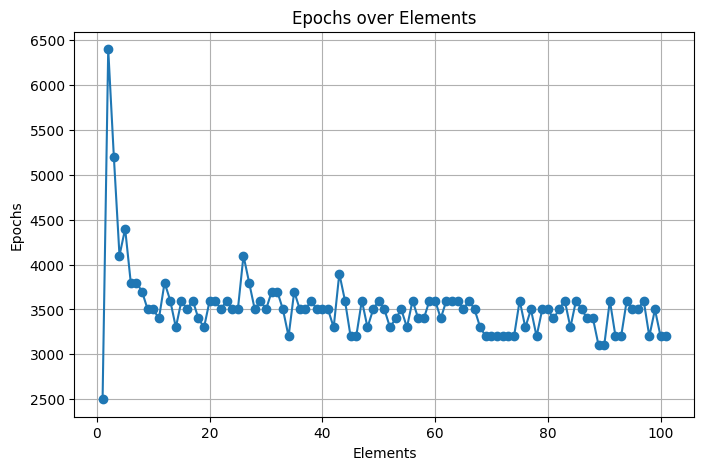

In [18]:
import re
import matplotlib.pyplot as plt

def plot_epochs_over_elements(text):
    # Use regex to extract (element, epochs) pairs
    pattern = r'Done with (\d+)\. Trained for (\d+) epochs\.'
    matches = re.findall(pattern, text)

    if not matches:
        print("No matches found. Check your input format.")
        return

    # Convert to integers
    elements = [int(m[0]) for m in matches]
    epochs = [int(m[1]) for m in matches]

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(elements, epochs, marker='o')
    plt.title("Epochs over Elements")
    plt.xlabel("Elements")
    plt.ylabel("Epochs")
    plt.grid(True)
    plt.show()

plot_epochs_over_elements(text)

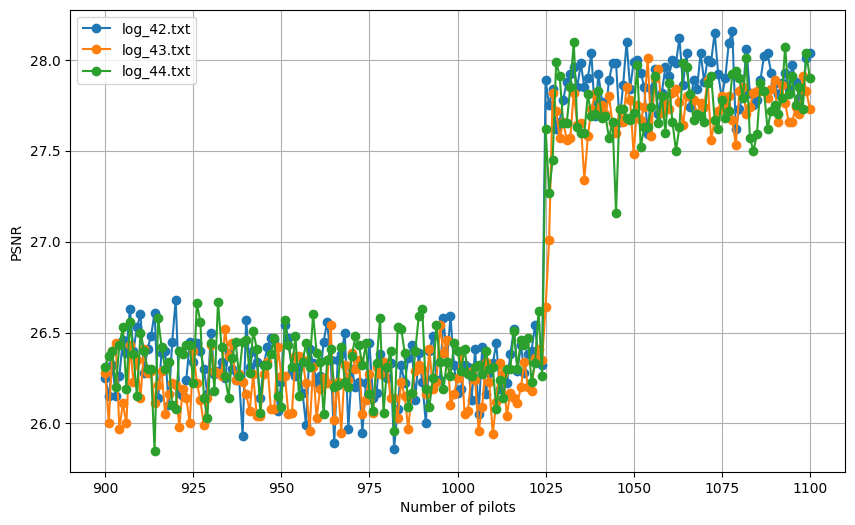

In [5]:
import re
import matplotlib.pyplot as plt

# List of file numbers
file_numbers = [42, 43, 44]

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through each file
for num in file_numbers:
    elements = []
    psnr = []

    with open(f'alignment/models/log_{num}.txt', 'r') as file:
        text = file.read()

    matches = re.findall(r'For (\d+) elements.*?PSNR of ([\d\.]+)', text)

    for match in matches:
        elements.append(int(match[0]))
        psnr.append(float(match[1]))

    # Plot for this file
    plt.plot(elements, psnr, marker='o', label=f'log_{num}.txt')

# Final plot settings
plt.xlabel('Number of pilots')
plt.ylabel('PSNR')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
%cd ..

import os
import torch
import torch.nn as nn
import torch.optim as optim
import copy

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

from alignment.alignment_utils import load_deep_jscc, get_batch_psnr
from alignment.alignment_model import _ConvolutionalAlignment, _LinearAlignment, AlignedDeepJSCC
from utils import image_normalization
import matplotlib.pyplot as plt

from dataset import Vanilla
from model import DeepJSCC
from tqdm import tqdm
import pickle
import random
import numpy as np

import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from torch.utils.data import DataLoader, Subset

/home/lorenzo/repos/Deep-JSCC-PyTorch


In [12]:
with open(f"/home/lorenzo/repos/Deep-JSCC-PyTorch/alignment/models/incremental_44/aligner_1000.pkl", 'rb') as f:
    model = pickle.load(f)

model.conv.weight

Parameter containing:
tensor([[[[ 4.3498e-03, -1.1272e-02, -3.8254e-03, -4.9296e-03, -2.1612e-03],
          [ 1.1373e-02,  8.9537e-03,  1.5804e-02,  1.0554e-02, -3.8623e-03],
          [-2.2750e-02, -3.6536e-02, -6.1654e-02, -4.0139e-03, -7.4263e-03],
          [ 9.1816e-03,  2.5487e-02, -3.9954e-02,  4.3402e-03,  1.4762e-02],
          [ 5.4176e-03, -2.5901e-03, -1.1643e-03, -1.3738e-02,  8.3917e-03]],

         [[ 1.3295e-02, -5.4055e-03, -1.5937e-02, -2.1127e-02,  8.2195e-03],
          [-5.2142e-03,  3.3577e-02, -4.1522e-02,  6.3669e-02, -1.3474e-02],
          [-1.2433e-02, -5.5661e-02, -3.4708e-02,  3.3812e-02, -4.2235e-02],
          [-6.7544e-04,  6.0504e-02, -8.1239e-02,  2.2119e-02,  7.2531e-03],
          [ 3.5639e-03, -2.2046e-03, -8.8278e-03, -3.7902e-02,  1.7819e-02]],

         [[-1.4124e-02, -4.8925e-02,  2.0648e-02,  1.1038e-02,  8.8263e-03],
          [-3.4267e-02, -3.4422e-02,  1.0459e-01, -4.6517e-02,  9.0552e-03],
          [ 2.6837e-02,  6.1946e-02,  4.4308e-02, 

In [13]:
with open(f"/home/lorenzo/repos/Deep-JSCC-PyTorch/alignment/models/incremental_43/aligner_1000.pkl", 'rb') as f:
    model = pickle.load(f)

model.conv.weight

Parameter containing:
tensor([[[[-8.3124e-03,  2.1632e-02, -1.4329e-02, -6.3754e-03,  1.7533e-03],
          [ 6.9460e-03,  6.3825e-03,  3.3036e-02,  1.4038e-02, -4.6225e-03],
          [-3.2526e-03, -6.1725e-02, -8.0851e-02, -2.6478e-03, -9.8282e-03],
          [ 1.0180e-02,  4.0155e-02, -5.0754e-02, -1.1768e-03,  1.8071e-02],
          [-7.4249e-03,  9.9232e-03,  1.8407e-02, -1.5854e-02,  4.7550e-03]],

         [[ 1.3844e-02, -2.7492e-02, -1.1403e-02,  8.3908e-04, -7.0390e-03],
          [ 1.2155e-02,  1.7691e-02, -2.8534e-02,  1.0331e-02, -8.9467e-03],
          [-4.1626e-02,  4.6450e-03, -6.1658e-02,  1.5966e-02, -1.1044e-02],
          [ 1.2122e-02, -4.9004e-03, -2.0408e-02,  3.8717e-02,  5.4556e-03],
          [-6.2768e-04, -1.8618e-03,  9.1956e-03, -5.4828e-02,  5.0975e-03]],

         [[-1.4683e-02, -5.4747e-02,  4.4860e-02,  8.0507e-03,  5.1839e-03],
          [-4.4193e-02, -1.1285e-02,  6.8547e-02, -5.1556e-02,  6.5185e-03],
          [ 3.4665e-02,  6.5263e-02,  3.8584e-02, 

# Clustering

In [8]:
batch_size = 1024
c = 8
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=False)

Computing model outputs: 100%|██████████| 782/782 [00:08<00:00, 93.19it/s] 


In [20]:
num_pca_components = 1000
num_clusters = 20
side = 0

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

loader = DataLoader(data, batch_size=len(data))
images = next(iter(loader))[side]  # shape: (N, C, H, W)

N, C, H, W = images.shape

In [22]:
# Flatten images to vectors
flat_images = images.view(N, -1)  # shape: (N, C*H*W)

In [ ]:
# Do PCA
# pca = PCA(n_components=num_pca_components)
# pca_features = pca.fit_transform(flat_images.numpy())  # shape: (N, num_pca_components)

: 

In [23]:
# KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=seed)
cluster_labels = kmeans.fit_predict(flat_images)

In [24]:
# Compute mean image for each cluster
centroid_images = []
for cluster_id in range(num_clusters):
    # Indices of images in this cluster
    indices = torch.tensor(cluster_labels) == cluster_id
    indices = torch.nonzero(indices).squeeze()

    subset = Subset(data, indices)
    loader = DataLoader(subset, batch_size=len(subset))
    
    # Get all images in this cluster
    cluster_images = next(iter(loader))  # shape: (num_in_cluster, C, H, W)
    
    mean_image_in = cluster_images[0].mean(dim=0)  # mean over batch dimension
    mean_image_out = cluster_images[1].mean(dim=0)  # mean over batch dimension
    centroid_images.append([mean_image_in, mean_image_out])

In [25]:
# Centroid is random element from cluster
centroid_images = []

for cluster_id in range(num_clusters):
    # Indices of images in this cluster
    indices = torch.tensor(cluster_labels) == cluster_id
    indices = torch.nonzero(indices).squeeze()
    subset = Subset(data, indices)
    
    # Pick a random index from this subset
    random_idx_in_subset = random.choice(range(len(subset)))
    random_image = subset[random_idx_in_subset]  # get the random image
    
    centroid_images.append(random_image)

In [26]:
# New dataset with centroid images
class CentroidDataset(Dataset):
    def __init__(self, centroids):
        self.centroids = centroids

    def __len__(self):
        return len(self.centroids)

    def __getitem__(self, idx):
        return self.centroids[idx]

centroid_dataset = CentroidDataset(centroid_images)

In [27]:
dataloader = DataLoader(centroid_dataset, batch_size=batch_size, shuffle=True)

# initialize aligner
aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5)
epochs = 10000
criterion = nn.MSELoss()
optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

# train aligner
for _ in range(epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = aligner(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# save aligner
with open(r'alignment/models/clustering/aligner_'+str(num_clusters)+'.pkl', 'wb') as f:
    pickle.dump(aligner, f)

In [28]:
aligner_fp = r"alignment/models/clustering/aligner_100.pkl"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

# load aligned model
aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

# validate and print
print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 28.39


In [32]:
aligner_fp = r"alignment/models/incremental_42/aligner_100.pkl"
model1_fp = r'alignment/models/upscaled_42.pkl'
model2_fp = r'alignment/models/upscaled_43.pkl'

c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

# load aligned model
aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

# validate and print
print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 26.28
